In [2]:
import numpy as np
import pandas as pd
import collections

import os

import pickle
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import precision_recall_fscore_support, mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KDTree



import seaborn as sns

# multi objective optimization
import optuna
import plotly.express as px
from pathlib import Path

import shap
# supress warnings
import warnings
warnings.filterwarnings("ignore")

def make_prediction(M, X, model, UQ=False, X_train=None, y_mean=0.0, y_std=1.0):
    """
    Predict bias with optional 1-σ proxy for Random-Forest models.

    For RF with UQ=True we build the (n_samples, n_trees) prediction
    matrix, take the 16th/84th percentiles across trees, and return
    the half-width (upper-lower) as a spread measure.
    """
    if model == "RF":
        if UQ:
            # stack predictions from every tree → shape (n_samples, n_trees)
            preds = np.column_stack([t.predict(X) for t in M.estimators_])
            bias  = preds.mean(axis=1)
            spread = np.quantile(preds, 0.84, axis=1) - np.quantile(preds, 0.16, axis=1)
            return bias, spread
        else:
            bias = M.predict(X)
            return bias, bias                              # dummy σ

    if model in {"XGB", "NN"}:
        bias = M.predict(X)
        return bias, bias

    if model == "GPR":
        if UQ:
            bias, sigma = M.predict(X, return_std=True)
            sigma = sigma * y_std + y_mean
        else:
            bias = np.concatenate([M.predict(X[i:i + 100_000])
                                    for i in range(0, len(X), 100_000)])
            sigma = bias
        return bias * y_std + y_mean, sigma

    if model in {"Ridge", "Ransac"}:
        bias = M.predict(X) * y_std + y_mean
        return bias, bias


    raise ValueError(f"Unknown model type: {model}")

def bias_correct(model_path, df, vars_to_fix, uq=False, proxy_name="TCCON"):
    """
    Apply the trained bias-correction model saved at *model_path* to *df*.
    Updates the columns in *vars_to_fix* in-place and (optionally) writes
    `bias_correction_uncert`.
    """
    meta = pd.read_pickle(model_path)
    X_mean, X_std = meta["X_mean"], meta["X_std"]
    y_mean, y_std = meta["y_mean"], meta["y_std"]
    model, feats, mdl_name = meta["TrainedModel"], meta["features"], meta["model"]

    X = df[feats]
    if mdl_name != "RF":                      # RF is already in native scale
        X = (X - X_mean) / X_std

    bias, sigma = make_prediction(model, X, mdl_name, UQ=uq, y_mean=y_mean, y_std=y_std)

    for v in vars_to_fix:
        df[v] = df[v] - bias

    if uq:
        df["bias_correction_uncert"] = sigma

    return df

def calc_SA_bias(xco2, sa_id):
    """
    Return (xco2 - SA median) with vectorised logic.
    Assumes *sa_id* is already sorted.
    """
    print("recalculating SA bias …")
    out = np.empty_like(xco2, dtype=float)
    idx_start = 0
    for sa, cnt in zip(*np.unique(sa_id, return_counts=True)):
        sl = slice(idx_start, idx_start + cnt)
        vals = xco2[sl]
        out[sl] = vals - np.median(vals) if cnt > 10 else np.nan
        idx_start += cnt
    return out


def train_rf(df, y, feats, *, cw=(1., 1.), w=None, rs=42):
    rf = RandomForestClassifier(
        n_estimators = 100,
        max_depth = 12,
        max_samples = len(df) // 2,
        min_samples_leaf = 10,
        max_features = "sqrt",
        class_weight = {0: cw[0], 1: cw[1]},
        n_jobs = -1,
        random_state= rs,
        verbose = 0,
    )
    rf.fit(df[feats], y, sample_weight=w)
    return rf


def sounding_fraction(df: pd.DataFrame, res_deg: int = 4) -> np.ndarray:
    """
    Fraction of soundings per equal-angle grid cell, scaled 0-100.
    """
    print("  • computing sounding-density grid …")
    lon, lat = df["longitude"].to_numpy(), df["latitude"].to_numpy()
    lon_e = np.arange(-180, 180 + res_deg, res_deg)
    lat_e = np.arange( -90,  90 + res_deg, res_deg)
    counts, _, _ = np.histogram2d(lon, lat, bins=[lon_e, lat_e])
    # look-up table → each sounding gets its cell count
    # (np.digitize gives 1-based indices)
    col = np.digitize(lon, lon_e) - 1
    row = np.digitize(lat, lat_e) - 1
    cell = counts.T[row, col]
    # convert to “% of mean monthly” like the original script
    n_month = len(df) / 12.0
    frac = (cell / n_month) * 100.0
    return frac / np.nanmax(frac) * 100     # normalise 0-100

def SA_label_density_weighting(df: pd.DataFrame,
                               gamma: float = 0.0,
                               res_deg: int = 4) -> pd.DataFrame:
    """
    Add column `SA_label_density_weighting` = |bias| * (1+γ·density).
    When γ==0 this collapses to |bias| 
    """
    if "sounding_fraction" not in df.columns:
        df["sounding_fraction"] = sounding_fraction(df, res_deg)
    df["SA_label_density_weighting"] = (
        np.abs(df["xco2raw_SA_bias"]) * (1.0 + gamma * df["sounding_fraction"])
    )
    return df


def tc_label(diff: pd.Series, pct: int) -> pd.Series:
    thr = np.nanpercentile(np.abs(diff), pct)
    return (np.abs(diff) > thr).astype(int)

def sa_binary_label(weighted_bias: pd.Series, pct: int) -> pd.Series:
    thr = np.nanpercentile(np.abs(weighted_bias), pct)
    return (np.abs(weighted_bias) > thr).astype(int)


def weight_tccon(df: pd.DataFrame) -> pd.DataFrame:
    cnt = df["tccon_name"].value_counts()
    df["weights"] = 1.0 / df["tccon_name"].map(cnt)
    df["weights"] /= df["weights"].sum()
    return df

# --------------------------------------------------------
def train_rf(df, y, feats, *, cw=(1.0, 1.0), w=None, rs=42):
    rf = RandomForestClassifier(
        n_estimators=100, max_depth=12, max_samples=len(df)//2,
        min_samples_leaf=10, max_features="sqrt",
        class_weight={0: cw[0], 1: cw[1]},
        n_jobs=-1, random_state=rs, verbose=0,
    )
    rf.fit(df[feats], y, sample_weight=w)
    return rf


def build_ternary_filter(
        *,
        data_train          : pd.DataFrame,
        data_test           : pd.DataFrame,
        feats_small_area_all,          # (land_feats , ocean_feats)
        feats_tccon_all,               # (land_feats , ocean_feats)
        percentile_lnd      = 70,
        percentile_ocn      = 50,
        abstention_threshold_lnd = 1.25,
        abstention_threshold_ocn = 1.05,
        tccon_weighting     = True,    # bool or {"land":…, "ocean":…}
        class_weight        = None,
        gamma_sa            = 0.000,     
        sa_res_deg          = 4,       
        save                = False,
):
    if isinstance(tccon_weighting, dict):
        wt_land  = bool(tccon_weighting.get("land" , False))
        wt_ocn   = bool(tccon_weighting.get("ocean", False))
    else:
        wt_land = wt_ocn = bool(tccon_weighting)

    if class_weight is None:
        class_weight = dict(tc_lnd=(1,1), tc_ocn=(1,1),
                            sa_lnd=(1,1), sa_ocn=(1,1))

    ft_tc_lnd, ft_tc_ocn = feats_tccon_all
    ft_sa_lnd, ft_sa_ocn = feats_small_area_all

    land_tr = data_train[data_train["land_fraction"] == 100].copy()
    ocn_tr  = data_train[data_train["land_fraction"] < 100].copy()

    land_tr = SA_label_density_weighting(land_tr, gamma_sa, sa_res_deg)
    ocn_tr  = SA_label_density_weighting(ocn_tr , gamma_sa, sa_res_deg)

    def _train_tc(df, feats, pct, cw, weight):
        df = df[df["xco2tccon"].notna()].copy()
        if weight: df = weight_tccon(df)
        y = tc_label(df["xco2MLcorr"] - df["xco2tccon"], pct)
        return train_rf(df, y, feats, cw=cw, w=df.get("weights"))

    M_tc_lnd = _train_tc(land_tr, ft_tc_lnd, percentile_lnd,
                         class_weight["tc_lnd"], wt_land)
    M_tc_ocn = _train_tc(ocn_tr , ft_tc_ocn, percentile_ocn,
                         class_weight["tc_ocn"], wt_ocn )

    def _train_sa(df, feats, pct, cw):
        df = df[np.isfinite(df["SA_label_density_weighting"])].copy()
        y  = sa_binary_label(df["SA_label_density_weighting"], pct)
        return train_rf(df, y, feats, cw=cw)

    M_sa_lnd = _train_sa(land_tr, ft_sa_lnd, percentile_lnd,
                         class_weight["sa_lnd"])
    M_sa_ocn = _train_sa(ocn_tr , ft_sa_ocn, percentile_ocn,
                         class_weight["sa_ocn"])

    def _apply(df):
        df = df.copy()
        is_land = df["land_fraction"] == 100

        df.loc[ is_land, "TCCON_flag"] = M_tc_lnd.predict(df.loc[ is_land, ft_tc_lnd])
        df.loc[~is_land, "TCCON_flag"] = M_tc_ocn.predict(df.loc[~is_land, ft_tc_ocn])

        df.loc[ is_land, "SA_flag"] = M_sa_lnd.predict(df.loc[ is_land, ft_sa_lnd])
        df.loc[~is_land, "SA_flag"] = M_sa_ocn.predict(df.loc[~is_land, ft_sa_ocn])

        σb = df["bias_correction_uncert"];  σr = df["xco2_uncertainty"]
        df["abst_metric"] = np.sqrt(np.maximum(σb**2 - σr**2, 0))
        df["abst_flag"]   = 1
        df.loc[ is_land & (df["abst_metric"] <= abstention_threshold_lnd), "abst_flag"] = 0
        df.loc[~is_land & (df["abst_metric"] <= abstention_threshold_ocn), "abst_flag"] = 0

        qf = np.full(len(df), 2, int)

        # QF = 0 
        cond_q0 = (df["TCCON_flag"]==0) & (df["SA_flag"]==0) & (df["abst_flag"]==0)
        qf[cond_q0] = 0

        # QF = 1
        cond_q1_land  =  is_land & (df["TCCON_flag"]==0) & ( (df["SA_flag"]==0) | (df["abst_flag"]==0) )
        cond_q1_ocn   = (~is_land) & ( (df["TCCON_flag"]==0) | (df["SA_flag"]==0) | (df["abst_flag"]==0) )
        qf[cond_q1_land | cond_q1_ocn] = np.minimum(qf[cond_q1_land | cond_q1_ocn], 1)

        df["xco2_quality_flag_b112"] = qf
        return df

    data_train = _apply(data_train)
    data_test  = _apply(data_test)

    if save:
        for tag, mdl in [("tc_lnd", M_tc_lnd), ("tc_ocn", M_tc_ocn),
                         ("sa_lnd", M_sa_lnd), ("sa_ocn", M_sa_ocn)]:
            with open(f"{tag}.p", "wb") as f:
                pickle.dump(mdl, f)

    return data_train, data_test, M_tc_lnd, M_tc_ocn, M_sa_lnd, M_sa_ocn




def load_one(fp: Path) -> pd.DataFrame:
    """Load pickle as *copy* so we never modify in-place."""
    return pd.read_pickle(fp).copy()


def split_tccon(df: pd.DataFrame, n_random: int = 1_000_000) -> pd.DataFrame:
    """All TCCON rows + random subset of non-TCCON."""
    tc   = df[df["xco2tccon"] > 0]
    rest = df[df["xco2tccon"].isna()].sample(n_random, random_state=42)
    return pd.concat([tc, rest], ignore_index=True)


def apply_bias(df: pd.DataFrame, *, land: bool) -> pd.DataFrame:
    """Run TCCON (uq=True) + SA corrections, add xco2MLcorr."""
    df = bias_correct(MODEL["TC_LND" if land else "TC_OCN"], df, ["xco2_raw"],
                      uq=True,  proxy_name="TCCON")
    df = bias_correct(MODEL["SA_LND" if land else "SA_OCN"], df, ["xco2_raw"],
                      uq=False, proxy_name="SA")
    df["xco2MLcorr"] = df["xco2_raw"]
    return df


def add_sa_bias(df: pd.DataFrame) -> pd.DataFrame:
    """Median-remove XCO2 inside each small area (SA)."""
    df = df.sort_values("SA")
    df["xco2raw_SA_bias"] = calc_SA_bias(df["xco2MLcorr"].to_numpy(),
                                         df["SA"].to_numpy())
    return df



In [3]:
NEW_FLAG = "xco2_quality_flag_b112"      # ML ternary flag (0/1/2)
OLD_FLAG = "xco2_quality_flag"           # operational B11 flag
MODEL_COLS = slice("CT_2022+NRT2023-1", "MACC_v21r1")   # inclusive slice


def _rmse(a, b) -> float:
    return np.sqrt(mean_squared_error(a, b))

def _pct(num, den) -> float:
    return np.nan if den == 0 else 100.0 * num / den

def _round_dict(d: dict, ndig: int = 2) -> dict:
    """Round every float in *d* to *ndig* decimals (in place)."""
    for k, v in d.items():
        if isinstance(v, float):
            d[k] = np.round(v, ndig)
    return d

def collect_stats(df: pd.DataFrame, tag: str) -> dict:
    """Return a dict of metrics for *df* (land+ocean)."""
    stats = {"set": tag, "n": int(len(df))}          

    land = df["land_fraction"] == 100
    ocn  = ~land
    mlqf01 = df[NEW_FLAG].isin([0, 1])

    for v in (0, 1, 2):
        n = int((df[NEW_FLAG] == v).sum())
        stats[f"n_mlqf{v}"] = n
        stats[f"p_mlqf{v}"] = _pct(n, len(df))

    stats["n_mlqf01"] = int(mlqf01.sum())
    stats["p_mlqf01"] = _pct(stats["n_mlqf01"], len(df))

    n_qf0 = int((df[OLD_FLAG] == 0).sum())
    stats["n_qf0"] = n_qf0
    stats["p_qf0"]  = _pct(n_qf0, len(df))

    for surf, mask in [("lnd", land), ("ocn", ocn)]:
        denom = mask.sum()
        for v in (0, 1):
            stats[f"p_mlqf{v}_{surf}"]  = _pct(((df[NEW_FLAG] == v) & mask).sum(), denom)
        stats[f"p_mlqf01_{surf}"] = _pct((mlqf01 & mask).sum(),            denom)
        stats[f"p_qf0_{surf}"] = _pct(((df[OLD_FLAG]==0) & mask).sum(), denom)

    for surf, mask in [("", np.ones(len(df), bool)), ("_lnd", land), ("_ocn", ocn)]:
        msum = mask.sum()
        stats[f"p_tc_pass{surf}"] = _pct(((df["TCCON_flag"]==0)&mask).sum(), msum)
        stats[f"p_sa_pass{surf}"] = _pct(((df["SA_flag"]   ==0)&mask).sum(), msum)
        stats[f"p_uq_pass{surf}"] = _pct(((df["abst_flag"] ==0)&mask).sum(), msum)

    def _tc_rmse(mask):
        sub = df[mask & df["xco2tccon"].notna()]
        return np.nan if sub.empty else _rmse(sub["xco2MLcorr"], sub["xco2tccon"])

    stats["rmse_tccon_lnd_mlqf0"] = _tc_rmse((df[NEW_FLAG]==0)&land)
    stats["rmse_tccon_ocn_mlqf0"] = _tc_rmse((df[NEW_FLAG]==0)&ocn)
    stats["rmse_tccon_lnd_mlqf01"] = _tc_rmse(mlqf01 & land)
    stats["rmse_tccon_ocn_mlqf01"] = _tc_rmse(mlqf01 & ocn)
    stats["rmse_tccon_mlqf01"] = _tc_rmse(mlqf01)

    base = df[OLD_FLAG]==0
    stats["rmse_tccon_lnd_b111_mlbc"] = _tc_rmse(base & land)
    stats["rmse_tccon_ocn_b111_mlbc"] = _tc_rmse(base & ocn)

    sub = df[base & land & df["xco2tccon"].notna()]
    stats["rmse_tccon_lnd_b111_bc"]   = np.nan if sub.empty else _rmse(sub["xco2"], sub["xco2tccon"])
    sub = df[base & ocn  & df["xco2tccon"].notna()]
    stats["rmse_tccon_ocn_b111_bc"]   = np.nan if sub.empty else _rmse(sub["xco2"], sub["xco2tccon"])

    stats["stddev_sa_lnd"] = np.nanstd(df.loc[(df[NEW_FLAG]==0)&land,"xco2raw_SA_bias"])
    stats["stddev_sa_ocn"] = np.nanstd(df.loc[(df[NEW_FLAG]==0)&ocn ,"xco2raw_SA_bias"])
    stats["stddev_sa_lnd_b111"] = np.nanstd(df.loc[(df[OLD_FLAG]==0)&land,"xco2raw_SA_bias"])
    stats["stddev_sa_ocn_b111"] = np.nanstd(df.loc[(df[OLD_FLAG]==0)&ocn ,"xco2raw_SA_bias"])
    stats["stddev_sa_lnd_mlqf01"] = np.nanstd(df.loc[mlqf01 & land,"xco2raw_SA_bias"])
    stats["stddev_sa_ocn_mlqf01"] = np.nanstd(df.loc[mlqf01 & ocn ,"xco2raw_SA_bias"])

    model_mean = df.loc[:, MODEL_COLS].mean(axis=1)
    def _model_rmse(mask, use_ml=True):
        sub = df[mask & (model_mean > 0)]
        if sub.empty: return np.nan
        return _rmse(model_mean[sub.index],
                     sub["xco2MLcorr"] if use_ml else sub["xco2"])

    stats["rmse_models_lnd_mlqf0"] = _model_rmse((df[NEW_FLAG]==0)&land)
    stats["rmse_models_ocn_mlqf0"] = _model_rmse((df[NEW_FLAG]==0)&ocn )
    stats["rmse_models_lnd_qf0"] = _model_rmse((df[OLD_FLAG]==0)&land, use_ml=False)
    stats["rmse_models_ocn_qf0"] = _model_rmse((df[OLD_FLAG]==0)&ocn , use_ml=False)
    stats["rmse_models_lnd_qf0_mlbc"] = _model_rmse((df[OLD_FLAG]==0)&land)
    stats["rmse_models_ocn_qf0_mlbc"] = _model_rmse((df[OLD_FLAG]==0)&ocn )
    stats["rmse_models_lnd_mlqf01"] = _model_rmse(mlqf01 & land)
    stats["rmse_models_ocn_mlqf01"] = _model_rmse(mlqf01 & ocn )
    stats["rmse_models_mlqf01"] = _model_rmse(mlqf01)

    return _round_dict(stats, 2)     # <<–– round here!

def summary(train_df=None, test_df=None, *, pretty=True):
    """
    Compute & display (or return) the statistics table.

    """
    if train_df is None: train_df = globals()["data_train"]
    if test_df  is None: test_df  = globals()["data_test"]

    table = (pd.DataFrame([
                collect_stats(train_df, "train"),
                collect_stats(test_df,  "test")
             ])
             .set_index("set")
             .round(2)                
             .T)

    if pretty:
        display(table.style.format(precision=2))
        return None
    return table

""" CONSTRUCT TERNARY FLAG WITH PRE TRAINED MODELS """
def apply_ternary_flag(
        df                  : pd.DataFrame,
        *,
        model_dir           : str | Path = ".",
        feats_tc_lnd        : list[str],
        feats_tc_ocn        : list[str],
        feats_sa_lnd        : list[str],
        feats_sa_ocn        : list[str],
        abs_thresh_lnd      : float = 1.25,
        abs_thresh_ocn      : float = 1.05,
        tc_lnd_name         : str = "tc_lnd.p",
        tc_ocn_name         : str = "tc_ocn.p",
        sa_lnd_name         : str = "sa_lnd.p",
        sa_ocn_name         : str = "sa_ocn.p",
        out_qf_col          : str = "xco2_quality_flag_b112",
        keep_bits           : bool = True,
    ) -> pd.DataFrame:
    """
    Parameters:
    
    df : DataFrame
        Must contain *all* feature columns + ``bias_correction_uncert`` and
        ``xco2_uncertainty``.
    model_dir : str | Path
        Folder that holds the four ``*.p`` pickles made earlier.
    feats_*   : list[str]
        The exact feature lists used during training.
    abs_thresh_* : float
        Land / ocean abstention thresholds.

    Returns:
    
    df_out : DataFrame
        A **copy** of *df* with a new ternary flag column (and the three
        sub-filter bit columns if *keep_bits* is True).
    """
    from pathlib import Path
    model_dir = Path(model_dir)

    with open(model_dir / tc_lnd_name, "rb") as f:
        M_tc_lnd = pickle.load(f)
    with open(model_dir / tc_ocn_name, "rb") as f:
        M_tc_ocn = pickle.load(f)
    with open(model_dir / sa_lnd_name, "rb") as f:
        M_sa_lnd = pickle.load(f)
    with open(model_dir / sa_ocn_name, "rb") as f:
        M_sa_ocn = pickle.load(f)

    out      = df.copy()
    is_land  = out["land_fraction"] == 100
    out.loc[ is_land, "TCCON_flag"] = M_tc_lnd.predict(out.loc[ is_land, feats_tc_lnd])
    out.loc[~is_land, "TCCON_flag"] = M_tc_ocn.predict(out.loc[~is_land, feats_tc_ocn])

    out.loc[ is_land, "SA_flag"]    = M_sa_lnd.predict(out.loc[ is_land, feats_sa_lnd])
    out.loc[~is_land, "SA_flag"]    = M_sa_ocn.predict(out.loc[~is_land, feats_sa_ocn])

    σb = out["bias_correction_uncert"]
    σr = out["xco2_uncertainty"]
    out["abst_metric"] = np.sqrt(np.maximum(σb**2 - σr**2, 0.))
    out["abst_flag"]   = 1
    out.loc[ is_land & (out["abst_metric"] <= abs_thresh_lnd), "abst_flag"] = 0
    out.loc[~is_land & (out["abst_metric"] <= abs_thresh_ocn), "abst_flag"] = 0

    qf = np.full(len(out), 2, dtype=int)

    cond_q0 = (out["TCCON_flag"]==0) & (out["SA_flag"]==0) & (out["abst_flag"]==0)
    qf[cond_q0] = 0


    cond_q1_land =  is_land & (out["TCCON_flag"]==0) & ( (out["SA_flag"]==0) | (out["abst_flag"]==0) )
    cond_q1_ocn  = (~is_land) & ( (out["TCCON_flag"]==0) | (out["SA_flag"]==0) | (out["abst_flag"]==0) )
    qf[cond_q1_land | cond_q1_ocn] = 1   # any previously 0 stay 0

    out[out_qf_col] = qf

    if not keep_bits:
        out = out.drop(columns=["TCCON_flag", "SA_flag", "abst_metric", "abst_flag"])

    return out


In [6]:
# Feature lists for the ternary filter
feats_sa_lnd = [
    "aod_diff","color_slice_noise_ratio_wco2","albedo_slope_wco2","chi2_o2a",
    "dp_o2a","t700","xco2_uncertainty","albedo_sco2","h_continuum_sco2",
    "airmass","h_continuum_wco2","dp_sco2","albedo_o2a","bias_correction_uncert",
    "color_slice_noise_ratio_sco2","dust_height","h_continuum_o2a","aod_water",
    "chi2_sco2","ice_height","h2o_scale","albedo_wco2","dp_abp","glint_angle",
    "albedo_slope_sco2","max_declocking_sco2","aod_dust","max_declocking_o2a",
    "color_slice_noise_ratio_o2a","zlo_o2a","aod_ice","tcwv","rms_rel_sco2",
    "aod_sulfate","aod_fine_apriori","co2_ratio_bc","aod_seasalt","chi2_wco2"
]

feats_sa_ocn = [
    "h_continuum_wco2","aod_seasalt","h_continuum_o2a","h_continuum_sco2","t700",
    "ice_height","h2o_scale","tcwv","deltaT","airmass","aod_diff","bias_correction_uncert",
    "h2o_ratio_bc","dws","glint_angle","co2_ratio_bc","aod_strataer",
    "aod_ice","aod_sulfate","chi2_wco2","color_slice_noise_ratio_o2a","xco2_uncertainty",
    "rms_rel_wco2","aod_water","aod_fine_apriori","co2_grad_del","albedo_sco2",
    "chi2_o2a","dp_sco2","albedo_o2a","chi2_sco2","albedo_wco2","aod_dust",
    "color_slice_noise_ratio_sco2","zlo_o2a","snr_sco2","rms_rel_o2a","max_declocking_o2a",
    "snr_wco2","max_declocking_sco2","tcwv_uncertainty","color_slice_noise_ratio_wco2",
    "rms_rel_sco2","max_declocking_wco2","snr_o2a","albedo_slope_sco2","dust_height",
    "albedo_slope_wco2","albedo_slope_o2a","aod_oc", "dp_abp"
]

feats_tc_lnd = [
    "bias_correction_uncert","altitude_stddev","co2_ratio_bc","t700","airmass","aod_sulfate",
    "aod_fine_apriori","aod_water","h2o_scale","tcwv","aod_diff","rms_rel_sco2","co2_grad_del",
    "rms_rel_wco2","albedo_o2a","tcwv_uncertainty","aod_dust","albedo_sco2","albedo_wco2",
    "snr_sco2","rms_rel_o2a","deltaT","zlo_o2a","snr_o2a","h2o_ratio_bc",
    "aod_ice","h_continuum_o2a","dws","h_continuum_wco2","h_continuum_sco2","xco2_uncertainty",
    "chi2_sco2","ice_height","albedo_slope_sco2","albedo_slope_wco2","dp","aod_oc","snr_wco2",
    "dpfrac","aod_strataer","color_slice_noise_ratio_wco2","chi2_o2a","max_declocking_sco2",
    "color_slice_noise_ratio_sco2","chi2_wco2","aod_seasalt"
]

feats_tc_ocn = [
    "aod_diff","color_slice_noise_ratio_wco2","albedo_slope_wco2","chi2_o2a","dp_o2a","t700",
    "xco2_uncertainty","albedo_sco2","h_continuum_sco2","airmass","h_continuum_wco2","dp_sco2",
    "albedo_o2a","bias_correction_uncert","color_slice_noise_ratio_sco2","dust_height",
    "h_continuum_o2a","aod_water","chi2_sco2","ice_height","h2o_scale","albedo_wco2",
    "glint_angle","albedo_slope_sco2","max_declocking_sco2","aod_dust","max_declocking_o2a",
    "color_slice_noise_ratio_o2a","zlo_o2a","aod_ice","tcwv","rms_rel_sco2","aod_sulfate",
    "aod_fine_apriori","co2_ratio_bc","aod_seasalt","chi2_wco2", "dp_abp"
]

# Bundle them exactly the way build_ternary_filter expects
feats_sa  = (feats_sa_lnd , feats_sa_ocn )
feats_tt  = (feats_tc_lnd , feats_tc_ocn)


FEATS_SA = (feats_sa_lnd, feats_sa_ocn)
FEATS_TC = (feats_tc_lnd, feats_tc_ocn)

ROOT = Path("/Users/williamkeely/Desktop/B11")
MODEL = {
    "TC_LND": ROOT / "current/bias_models_current/B112_bc_models/TCCON_Lnd/model_tc_lnd.p",
    "TC_OCN": ROOT / "current/bias_models_current/B112_bc_models/TCCON_Ocn/model_tc_ocn.p",
    "SA_LND": ROOT / "current/bias_models_current/B112_bc_models/SAA_Lnd/model_sa_lnd.p",
    "SA_OCN": ROOT / "current/bias_models_current/B112_bc_models/SAA_Ocn/model_sa_ocn.p",
}
DATA = {
    "LND": ROOT / "Data/Land",
    "OCN": ROOT / "Data/Ocean",
}
TRAIN_YEARS = [ "2015", "2016", "2017",  "2019", "2020", "2021", "2022"]
TEST_YEAR  = "2021"


In [7]:
data_train, data_test = pd.DataFrame(), pd.DataFrame()

for yr in TRAIN_YEARS:
    # 1. load
    land = load_one(DATA["LND"] / f"PreLoadB112_ununbalanced_5M_LndNDGL_qfNone_{yr}.pkl")
    ocn = load_one(DATA["OCN"] / f"PreLoadB112_ununbalanced_5M_SeaGL_qfNone_{yr}.pkl")

    # 2. keep all TCCON rows + random subset of others
    land = split_tccon(land)
    ocn = split_tccon(ocn)

    # 3. two-stage bias correction
    land = apply_bias(land, land=True)     
    ocn = apply_bias(ocn,  land=False)    

    # 4. add ML-corrected XCO2 + SA bias
    year_df = pd.concat([land, ocn], ignore_index=True)
    year_df = add_sa_bias(year_df)

    data_train = pd.concat([data_train, year_df], ignore_index=True)


land = load_one(DATA["LND"] / f"PreLoadB112_ununbalanced_5M_LndNDGL_qfNone_{TEST_YEAR}.pkl")
ocn = load_one(DATA["OCN"] / f"PreLoadB112_ununbalanced_5M_SeaGL_qfNone_{TEST_YEAR}.pkl")

land = apply_bias(land, land=True)
ocn = apply_bias(ocn,  land=False)

data_test = pd.concat([land, ocn], ignore_index=True)
data_test = add_sa_bias(data_test)

for df in (data_train, data_test):
    df["aod_diff"] = df["aod_total"] - df["aod_total_apriori"]




recalculating SA bias …
recalculating SA bias …
recalculating SA bias …
recalculating SA bias …
recalculating SA bias …
recalculating SA bias …
recalculating SA bias …
recalculating SA bias …


In [8]:
# -------------  CONFIG  ------------------------------------------
P_LAND  = 65    # percentile threshold for land (TC & SA)
P_OCEAN = 50    # percentile threshold for ocean
ABS_THRESH_LND = 1.30    # abstention threshold  (Chris metric)
ABS_THRESH_OCN = 1.05
CLASS_WEIGHT = dict(
    tc_lnd=(1.0, 1.0),
    tc_ocn=(1.3, 1.0),
    sa_lnd=(1.0, 1.15),
    sa_ocn=(1.0, 1.0),
)
SAVE_RF = False            # dump *.p models?





data_train, data_test, M_tc_lnd, M_tc_ocn, M_sa_lnd, M_sa_ocn = build_ternary_filter(
    data_train = data_train,
    data_test = data_test,
    feats_small_area_all = feats_sa,     # (land-list , ocean-list)
    feats_tccon_all = feats_tt,     # (land-list , ocean-list)
    class_weight=CLASS_WEIGHT,
    percentile_lnd = P_LAND,
    percentile_ocn  = P_OCEAN,
    abstention_threshold_lnd = ABS_THRESH_LND,
    abstention_threshold_ocn = ABS_THRESH_OCN,
    tccon_weighting = {"land":True, "ocean":True},         # TCCON weighting
    save = True,
)

summary()

  • computing sounding-density grid …
  • computing sounding-density grid …


Subset for SHAP: 100,000 rows (60,000 land • 40,000 ocean)


SHAP: 100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


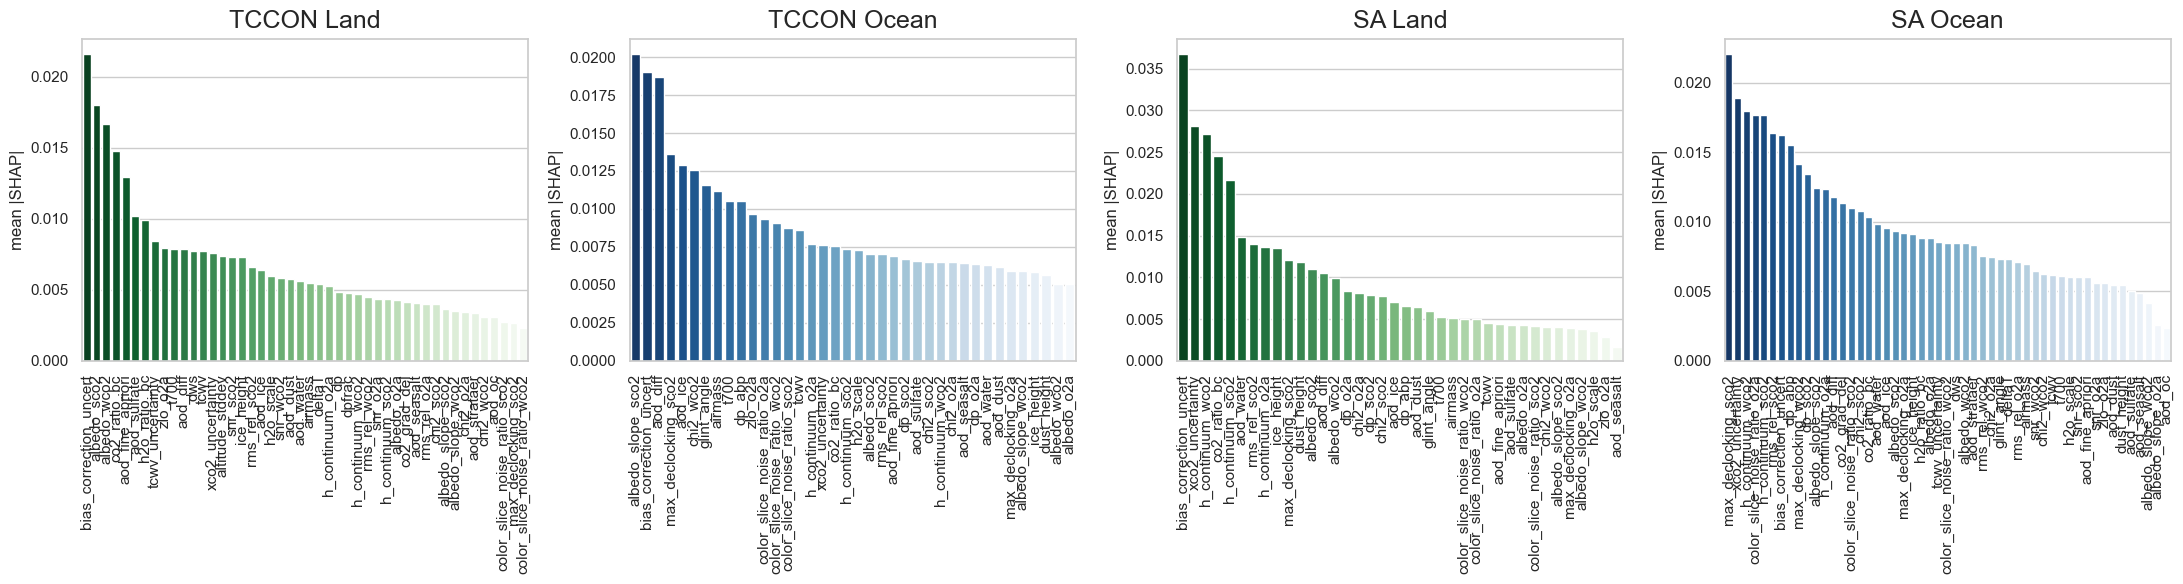

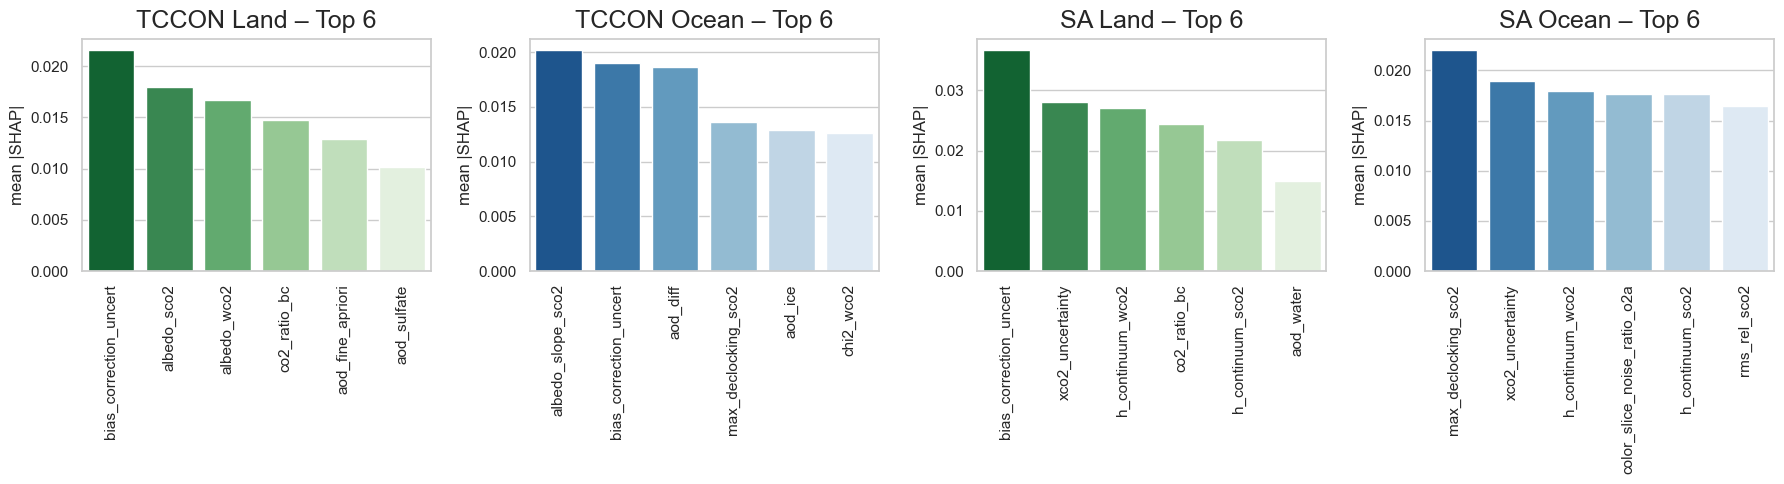

In [9]:
import numpy as np, pandas as pd, seaborn as sns, shap, matplotlib.pyplot as plt
from tqdm.auto import tqdm


data_all = pd.concat([data_train, data_test], ignore_index=True)

def make_subset(df, *, n_land=60_000, n_ocn=40_000, seed=42):
    land = df[df["land_fraction"] == 100 ].sample(n=min(n_land, df["land_fraction"].eq(100).sum()),
                                                  random_state=seed)
    ocn  = df[df["land_fraction"] < 100 ].sample(n=min(n_ocn , df["land_fraction"].lt(100).sum()),
                                                  random_state=seed)
    sub  = pd.concat([land, ocn], ignore_index=True)
    print(f"Subset for SHAP: {len(sub):,} rows "
          f"({len(land):,} land • {len(ocn):,} ocean)")
    return sub

data_sub = make_subset(data_all)          # ~100 k rows


models = dict(
    TC_LND = (M_tc_lnd, feats_tc_lnd, "TCCON Land",  "Greens_r"),
    TC_OCN = (M_tc_ocn, feats_tc_ocn, "TCCON Ocean", "Blues_r"),
    SA_LND = (M_sa_lnd, feats_sa_lnd, "SA Land",     "Greens_r"),
    SA_OCN = (M_sa_ocn, feats_sa_ocn, "SA Ocean",    "Blues_r"),
)


SHAP_ROWS = 3_000     
BACKGROUND_SZ = 100     
TOP_N = 6
sns.set_theme(style="whitegrid")
XTICK_FSIZE = 11
TITLE_FSIZE = 18


importance   = {}         
for tag, (rf, feats, friendly, pal) in tqdm(models.items(), desc="SHAP"):
    X = data_sub[feats].sample(n=min(SHAP_ROWS, len(data_sub)), random_state=0)
    bg = shap.sample(X, BACKGROUND_SZ, random_state=1)

    explainer = shap.TreeExplainer(rf, data=bg, feature_perturbation="interventional")
    sv = explainer.shap_values(X, approximate=True)[1]    # class-1
    mean_imp = np.abs(sv).mean(0)
    order = np.argsort(mean_imp)[::-1]
    importance[tag] = (np.array(feats)[order], mean_imp[order])


fig1, axs1 = plt.subplots(1, 4, figsize=(22, 6), sharey=False)
for ax, (tag, (_, _, title, palette)) in zip(axs1, models.items()):
    names, imps = importance[tag]
    sns.barplot(x=names, y=imps, palette=palette, ax=ax)
    ax.set_xticklabels(names, rotation=90, fontsize=XTICK_FSIZE)
    ax.set_xlabel("")
    ax.set_ylabel("mean |SHAP|", fontsize=12)
    ax.set_title(title, fontsize=TITLE_FSIZE, pad=8)
plt.tight_layout()
fig1.savefig("shap_all_models_row.pdf", dpi=300)


fig2, axs2 = plt.subplots(1, 4, figsize=(18, 5), sharey=False)
for ax, (tag, (_, _, title, palette)) in zip(axs2, models.items()):
    names, imps = importance[tag]
    sns.barplot(x=names[:TOP_N], y=imps[:TOP_N], palette=palette, ax=ax)
    ax.set_xticklabels(names[:TOP_N], rotation=90, fontsize=XTICK_FSIZE)
    ax.set_xlabel("")
    ax.set_ylabel("mean |SHAP|", fontsize=12)
    ax.set_title(f"{title} – Top {TOP_N}", fontsize=TITLE_FSIZE, pad=8)
plt.tight_layout()
fig2.savefig("shap_top6_models_row.pdf", dpi=300)




In [12]:
def plot_qf_delta(
    df: pd.DataFrame,
    new_flag_col: str,
    old_flag_col: str,
    flag_value: int = 0,
    bins=(360 // 3, 180 // 3),
    vmin=-100, vmax=100,
    cmap="coolwarm",
    title=None,
    save_path: str | None = None,
):
    """
    Plot %-difference in spatial coverage for a given flag value
    (default: 0) between a *new* and an *old* quality-flag column.


    """
    new_mask = df[df[new_flag_col] == flag_value]
    old_mask = df[df[old_flag_col] == flag_value]

    new_cnt, xedges, yedges = np.histogram2d(
        new_mask["longitude"], new_mask["latitude"], bins=bins
    )
    old_cnt, *_ = np.histogram2d(
        old_mask["longitude"], old_mask["latitude"], bins=[xedges, yedges]
    )

    new_cnt  = new_cnt.astype(float)
    old_cnt  = old_cnt.astype(float)
    new_cnt[new_cnt == 0] = np.nan
    old_cnt[old_cnt == 0] = np.nan

    delta = (new_cnt - old_cnt) / old_cnt * 100.0

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())
    ax.coastlines(linewidth=1.0)
    ax.gridlines(draw_labels=False, linewidth=0.8, linestyle="dotted")

    im = ax.imshow(
        delta.T,
        origin="lower",
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
        vmin=vmin, vmax=vmax, cmap=cmap,
        transform=ccrs.PlateCarree(),
    )

    if title is None:
        title = f"Δ% coverage for QF = {flag_value}  (new – old)"
    ax.set_title(title, fontsize=11, pad=8)

    cb = plt.colorbar(im, ax=ax, orientation="horizontal", pad=0.06,
                      label="Relative change [%]")
    cb.ax.tick_params(labelsize=8)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
        plt.close()
    else:
        plt.show()

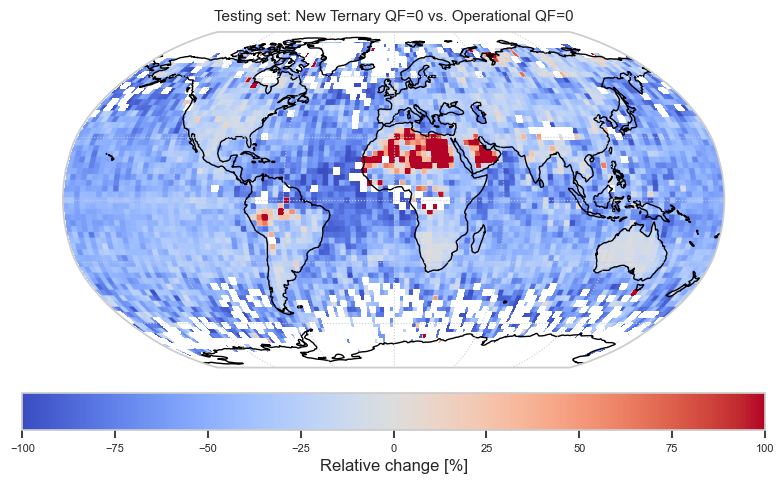

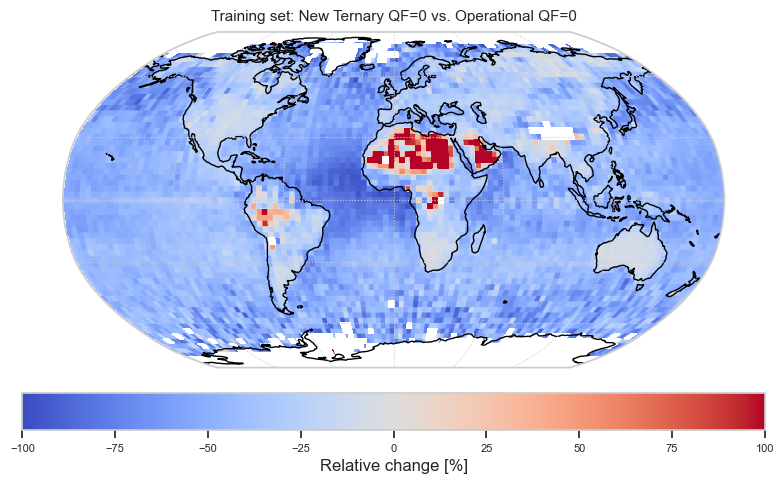

In [13]:
plot_qf_delta(
    data_test,
    new_flag_col="xco2_quality_flag_b112",
    old_flag_col="xco2_quality_flag",
    flag_value=0,
    title="Testing set: New Ternary QF=0 vs. Operational QF=0",
)

plot_qf_delta(
    data_train,
    new_flag_col="xco2_quality_flag_b112",
    old_flag_col="xco2_quality_flag",
    flag_value=0,
    title="Training set: New Ternary QF=0 vs. Operational QF=0",
)

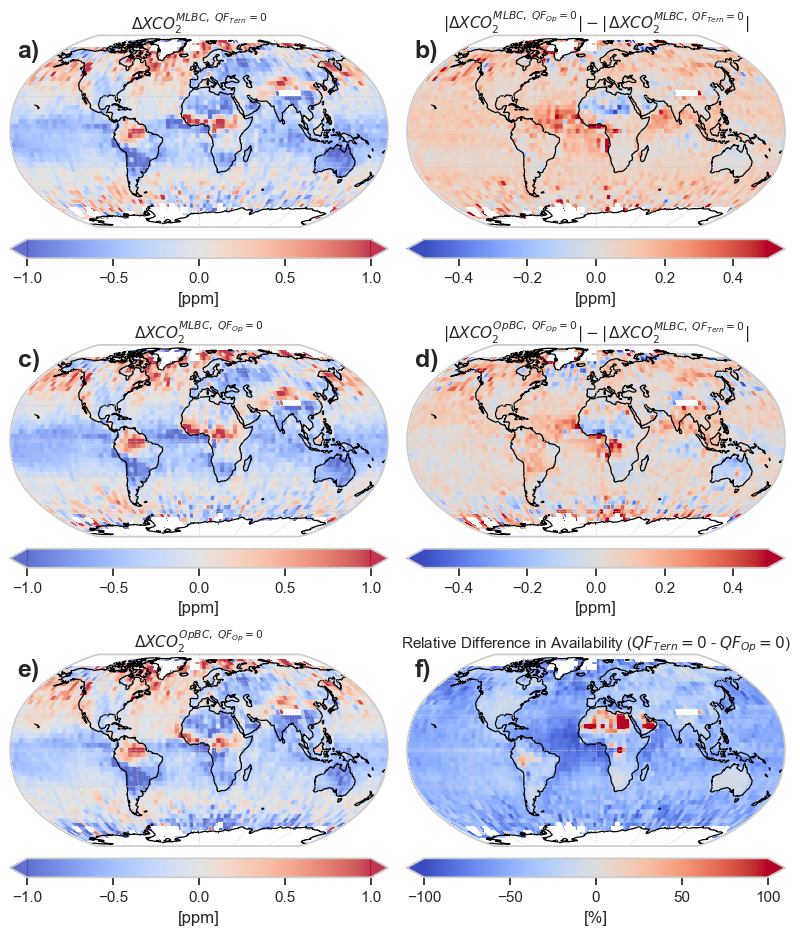

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


DF = pd.concat([data_train, data_test], ignore_index=True)
if "xco2_model" not in DF.columns:
    cols = DF.loc[:, "CT_2022+NRT2023-1":"MACC_v21r1"].columns
    DF["xco2_model"] = DF[cols].mean(axis=1)

DF = DF[DF["xco2_model"] > 0]           # keep only “valid-model” rows

data_mlqf0 = DF[DF["xco2_quality_flag_b112"] == 0]
data_opqf0 = DF[DF["xco2_quality_flag"] == 0]


def grid_mean(lon, lat, vals, *, res=4):
    lon_e = np.arange(-180, 180+res, res)
    lat_e = np.arange( -90,  90+res, res)
    cnt , _, _ = np.histogram2d(lon, lat, bins=[lon_e, lat_e])
    sm, _, _ = np.histogram2d(lon, lat, bins=[lon_e, lat_e], weights=vals)
    out = np.full_like(sm.T, np.nan, dtype=float)
    msk = cnt.T > 0
    out[msk] = sm.T[msk] / cnt.T[msk]
    return out, [lon_e[0], lon_e[-1], lat_e[0], lat_e[-1]]

def grid_count(lon, lat, *, res=4):
    """Simple 2-D histogram (counts per cell)."""
    lon_e = np.arange(-180, 180+res, res)
    lat_e = np.arange( -90,  90+res, res)
    cnt, _, _ = np.histogram2d(lon, lat, bins=[lon_e, lat_e])
    cnt = cnt.T
    cnt[cnt == 0] = np.nan           # keep NaN for empty cells
    return cnt, [lon_e[0], lon_e[-1], lat_e[0], lat_e[-1]]

def coast_grid(ax):
    ax.coastlines(linewidth=.9)
    ax.gridlines(linestyle=':', linewidth=.7, draw_labels=False)


ΔML_Q0 = r"$\Delta XCO_2^{MLBC,\;QF_{Tern}=0}$"
ΔML_OPQ0 = r"$\Delta XCO_2^{MLBC,\;QF_{Op}=0}$"
ΔOP = r"$\Delta XCO_2^{OpBC,\;QF_{Op}=0}$"
ΔABS1= r"$|\Delta XCO_2^{MLBC,\;QF_{Op}=0}|-|\,\Delta XCO_2^{MLBC,\;QF_{Tern}=0}|$"
ΔABS2 = r"$|\Delta XCO_2^{OpBC,\;QF_{Op}=0}|-|\,\Delta XCO_2^{MLBC,\;QF_{Tern}=0}|$"
AVAIL = r"Relative Difference in Availability ($QF_{Tern}=0$ - $QF_{Op}=0$)"

letters = ["a)","c)","e)","b)","d)","f)"]


fig, axs = plt.subplots(3, 2, figsize=(10, 12),
                        subplot_kw=dict(projection=ccrs.Robinson()))
fig.subplots_adjust(hspace=0.015, wspace=0.05)

# ---------- Panel a) ----------------------------------------------
ax = axs[0,0]; coast_grid(ax)
img, ext = grid_mean(data_mlqf0.longitude, data_mlqf0.latitude,
                     data_mlqf0.xco2MLcorr - data_mlqf0.xco2_model)
im = ax.imshow(img, origin='lower', extent=ext, cmap='coolwarm',
               vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha=.8)
ax.set_title(ΔML_Q0, fontsize=11, pad=3)
ax.text(0.02,0.98,letters[0],transform=ax.transAxes,va='top',weight='bold', fontsize=18)
fig.colorbar(im, ax=ax, orientation='horizontal',
             fraction=0.066, pad=0.04, extend='both', label='[ppm]')

# ---------- Panel c) ----------------------------------------------
ax = axs[1,0]; coast_grid(ax)
img, ext = grid_mean(data_opqf0.longitude, data_opqf0.latitude,
                     data_opqf0.xco2MLcorr - data_opqf0.xco2_model)
im = ax.imshow(img, origin='lower', extent=ext, cmap='coolwarm',
               vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha=.8)
ax.set_title(ΔML_OPQ0, fontsize=11, pad=3)
ax.text(0.02,0.98,letters[1],transform=ax.transAxes,va='top',weight='bold', fontsize=18)
fig.colorbar(im, ax=ax, orientation='horizontal',
             fraction=0.066, pad=0.04, extend='both', label='[ppm]')

# ---------- Panel e) ----------------------------------------------
ax = axs[2,0]; coast_grid(ax)
img, ext = grid_mean(data_opqf0.longitude, data_opqf0.latitude,
                     data_opqf0.xco2 - data_opqf0.xco2_model)
im = ax.imshow(img, origin='lower', extent=ext, cmap='coolwarm',
               vmin=-1, vmax=1, transform=ccrs.PlateCarree(), alpha=.8)
ax.set_title(ΔOP, fontsize=11, pad=3)
ax.text(0.02,0.98,letters[2],transform=ax.transAxes,va='top',weight='bold', fontsize=18)
fig.colorbar(im, ax=ax, orientation='horizontal',
             fraction=0.066, pad=0.04, extend='both', label='[ppm]')

# ---------- Panel b)  |ΔOp|-|ΔML| ----------------------------------
ax = axs[0,1]; coast_grid(ax)
abs_op , ext = grid_mean(data_opqf0.longitude, data_opqf0.latitude,
                         np.abs(data_opqf0.xco2MLcorr - data_opqf0.xco2_model))
abs_ml , _   = grid_mean(data_mlqf0.longitude, data_mlqf0.latitude,
                         np.abs(data_mlqf0.xco2MLcorr - data_mlqf0.xco2_model))
im = ax.imshow(abs_op - abs_ml, origin='lower', extent=ext, cmap='coolwarm',
               vmin=-0.5, vmax=0.5, transform=ccrs.PlateCarree())
ax.set_title(ΔABS1, fontsize=11, pad=3)
ax.text(0.02,0.98,letters[3],transform=ax.transAxes,va='top',weight='bold', fontsize=18)
fig.colorbar(im, ax=ax, orientation='horizontal',
             fraction=0.066, pad=0.04, extend='both', label='[ppm]')

# ---------- Panel d)  |ΔOpBC|-|ΔML| -------------------------------
ax = axs[1,1]; coast_grid(ax)
abs_opbc, ext = grid_mean(data_opqf0.longitude, data_opqf0.latitude,
                          np.abs(data_opqf0.xco2 - data_opqf0.xco2_model))
abs_ml , _  = grid_mean(data_mlqf0.longitude, data_mlqf0.latitude,
                          np.abs(data_mlqf0.xco2MLcorr - data_mlqf0.xco2_model))
im = ax.imshow(abs_opbc - abs_ml, origin='lower', extent=ext, cmap='coolwarm',
               vmin=-0.5, vmax=0.5, transform=ccrs.PlateCarree())
ax.set_title(ΔABS2, fontsize=11, pad=3)
ax.text(0.02,0.98,letters[4],transform=ax.transAxes,va='top',weight='bold', fontsize=18)
fig.colorbar(im, ax=ax, orientation='horizontal',
             fraction=0.066, pad=0.04, extend='both', label='[ppm]')

# ---------- Panel f)  availability diff ---------------------------
ax = axs[2,1]; coast_grid(ax)
cnt_ml, ext = grid_count(data_mlqf0.longitude, data_mlqf0.latitude)
cnt_op, _ = grid_count(data_opqf0.longitude, data_opqf0.latitude)
img = 100 * (cnt_ml - cnt_op) / cnt_op
im = ax.imshow(img, origin='lower', extent=ext, cmap='coolwarm',
               vmin=-100, vmax=100, transform=ccrs.PlateCarree())
ax.set_title(AVAIL, fontsize=11, pad=3)
ax.text(0.02,0.98,letters[5],transform=ax.transAxes,va='top',weight='bold', fontsize=18)
fig.colorbar(im, ax=ax, orientation='horizontal',
             fraction=0.066, pad=0.04, extend='both', label='[%]')

fig.savefig("FILTER_BIASES_AND_DIFFERENCES.pdf", dpi=300,
            bbox_inches='tight')
plt.show()


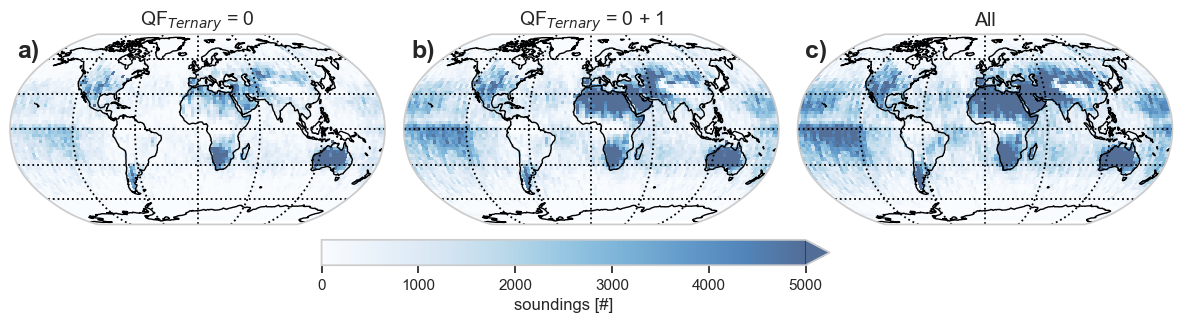

In [15]:
data_test_qf0 = data_test[data_test['xco2_quality_flag_b112'] == 0]
data_test_qf01 = data_test[data_test['xco2_quality_flag_b112'] != 2]
LETTERS    = ["a)", "b)", "c)"]
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.5, wspace=0.05)
axs = axs.ravel()

for i, data in enumerate([data_test_qf0, data_test_qf01, data_test]):
    result1, xedges, yedges = np.histogram2d(data['longitude'],data['latitude'],bins=[360//3, 180//3])
    # denominator, _, _, = np.histogram2d(data['longitude'],data['latitude'],bins=[xedges, yedges])
    # denominator[denominator==0.0] = np.nan

    # result = denominator / result1
    result = result1

    im = axs[i].imshow(result.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Blues',vmin = 0, vmax = 5000, transform=ccrs.PlateCarree(), alpha = 0.7)
    axs[i].coastlines(color = 'black', linewidth = 1.0)
    axs[i].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
    if i == 0:
        axs[i].set_title('QF$_{Ternary}$ = ' + str(i), fontsize=14)
        axs[i].text(0.02, 0.97, LETTERS[i], transform=axs[i].transAxes,
            ha="left", va="top", fontsize=18, weight="bold")
        cbar = fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.066, pad=0.04, extend='max', label='soundings [#]')
    if i == 1:
        axs[i].set_title('QF$_{Ternary}$ = 0 + 1', fontsize=14)
        axs[i].text(0.02, 0.97, LETTERS[i], transform=axs[i].transAxes,
            ha="left", va="top", fontsize=18, weight="bold")
    if i == 2:
        axs[i].set_title('All', fontsize=14)
        axs[i].text(0.02, 0.97, LETTERS[i], transform=axs[i].transAxes,
            ha="left", va="top", fontsize=18, weight="bold")
fig.savefig("QF_Ternary_Availability_Blues.pdf", dpi=300, bbox_inches='tight')
plt.show()

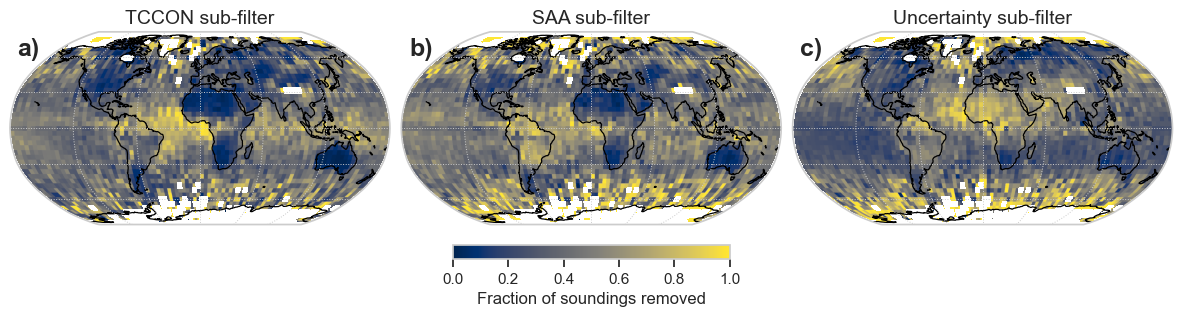

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs


def _edges(res=4):
    lon_e = np.arange(-180, 180 + res, res)
    lat_e = np.arange( -90,  90 + res, res)
    return lon_e, lat_e

def grid_count(lon, lat, *, res=4):
    lon_e, lat_e = _edges(res)
    cnt, _, _ = np.histogram2d(lon, lat, bins=[lon_e, lat_e])
    cnt = cnt.T
    cnt[cnt == 0] = np.nan          # keep NaN for empty cells
    return cnt, [lon_e[0], lon_e[-1], lat_e[0], lat_e[-1]]

def grid_sum(lon, lat, weights, *, res=4):
    lon_e, lat_e = _edges(res)
    sm, _, _ = np.histogram2d(lon, lat, bins=[lon_e, lat_e], weights=weights)
    return sm.T                     # transpose so rows = lat

res = 4
lon_e, lat_e = _edges(res)

# DF = pd.concat([data_train, data_test], ignore_index=True)   # full record
DF = data_test
SUB_FLAGS  = ["TCCON_flag", "SA_flag", "abst_flag"]          # 1 = removed
SUB_NAMES= ["TCCON sub-filter", "SAA sub-filter", "Uncertainty sub-filter"]
LETTERS = ["a)", "b)", "c)"]

hist_all, _ = grid_count(DF["longitude"], DF["latitude"], res=res)

def frac_raster(flag_name):
    removed = DF[flag_name].fillna(0).astype(float)          # 1 = removed
    num = grid_sum(DF["longitude"], DF["latitude"], removed, res=res)
    frac = np.divide(num, hist_all, where = ~np.isnan(hist_all))
    frac[np.isnan(hist_all)] = np.nan
    return frac

rasters = [frac_raster(f) for f in SUB_FLAGS]

import matplotlib.pyplot as plt, cartopy.crs as ccrs

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5),
                         subplot_kw=dict(projection=ccrs.Robinson()))
fig.subplots_adjust(wspace=0.03)

extent = [lon_e[0], lon_e[-1], lat_e[0], lat_e[-1]]

for ax, rast, name, letter in zip(axes, rasters, SUB_NAMES, LETTERS):
    im = ax.imshow(rast, origin="lower", extent=extent,
                   cmap="cividis", vmin=0, vmax=1,
                   transform=ccrs.PlateCarree())
    ax.coastlines(linewidth=0.9)
    ax.gridlines(linestyle=":", linewidth=0.7)
    ax.set_title(name, fontsize=14)
    ax.text(0.02, 0.97, letter, transform=ax.transAxes,
            ha="left", va="top", fontsize=18, weight="bold")

fig.colorbar(im, ax=axes.ravel().tolist(), orientation="horizontal",
             fraction=0.04, pad=0.06,
             label="Fraction of soundings removed")
fig.savefig("subfilter_fraction_removed_cividis.pdf",
            dpi=300, bbox_inches="tight")
plt.show()



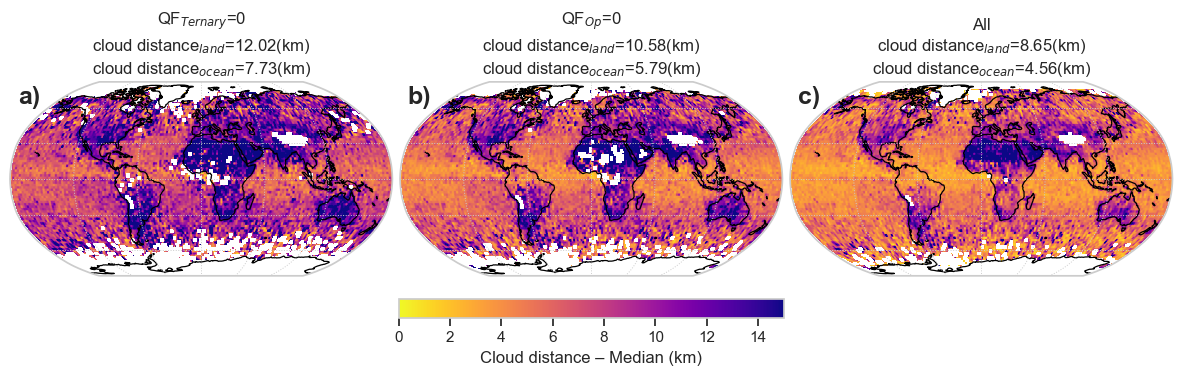

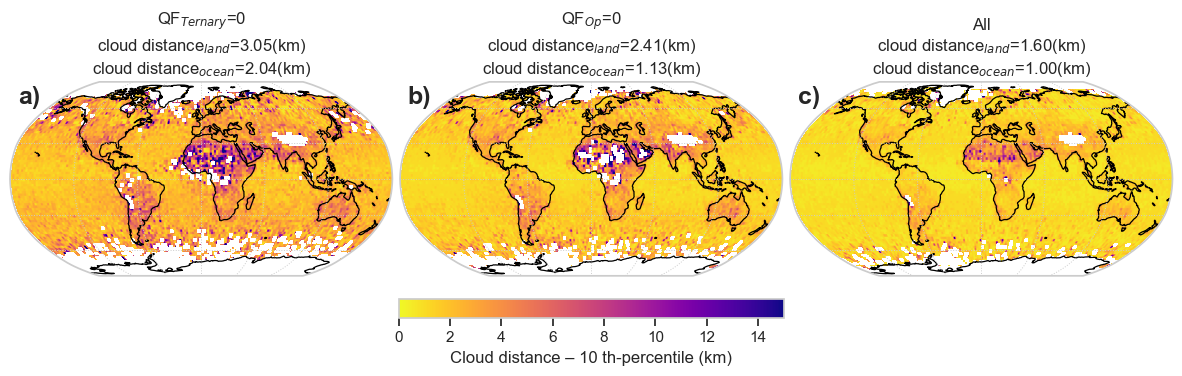

In [17]:
# Cloud-distance maps  –  median & 10 th-percentile 
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from scipy.stats import median_abs_deviation, binned_statistic_2d

cld_data = pd.concat([data_train, data_test], ignore_index=True)
cld_data = cld_data[cld_data["cld_dist"] > 0]

NEW_FLAG = "xco2_quality_flag_b112"
OLD_FLAG = "xco2_quality_flag"

subsets = [
    ("a)", "QF$_{Ternary}$=0",  cld_data[cld_data[NEW_FLAG] == 0]),
    ("b)", "QF$_{Op}$=0", cld_data[cld_data[OLD_FLAG] == 0]),
    ("c)", "All",      cld_data),
]

def bin_stat(df, func, res=2):
    lon_edges = np.arange(-180, 180 + res, res)
    lat_edges = np.arange(-90,   90 + res, res)
    Z, _, _, _ = binned_statistic_2d(
        df["longitude"], df["latitude"], df["cld_dist"],
        statistic=func, bins=[lon_edges, lat_edges]
    )
    return Z.T, lon_edges, lat_edges      # transpose → (lat, lon)

def land_ocean_stat(df, func):
    land = df["land_fraction"] == 100
    ocn  = ~land
    def _stat(s):  # value ± 1.4826*MAD
        arr = s["cld_dist"]
        val = func(arr)
        mad = 1.4826 * median_abs_deviation(arr, nan_policy="omit")
        return val, mad
    m_l, mad_l = _stat(df[land])
    m_o, mad_o = _stat(df[ocn])
    return m_l, mad_l, m_o, mad_o

def plot_panels(stat_name, func, *, cmap="plasma_r", vmax=15, fname=None,
                show_stats=True):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5),
                            subplot_kw=dict(projection=ccrs.Robinson()))
    fig.subplots_adjust(wspace=0.02)

    for ax, (lbl, ttl, df) in zip(axs, subsets):
        raster, x_e, y_e = bin_stat(df, func)
        im = ax.imshow(raster, origin="lower", cmap=cmap, vmin=0, vmax=vmax,
                       extent=[x_e[0], x_e[-1], y_e[0], y_e[-1]],
                       transform=ccrs.PlateCarree())
        ax.coastlines(linewidth=0.9)
        ax.gridlines(linestyle=":", linewidth=0.7)
        ax.text(0.02, 0.98, lbl, transform=ax.transAxes,
                ha="left", va="top", fontsize=18, weight="bold")

        if show_stats:
            m_l, mad_l, m_o, mad_o = land_ocean_stat(df, func)
            ax.set_title(f"{ttl}\n"
                         f"cloud distance$_{{land}}$={m_l:.2f}(km)\n"
                         f"cloud distance$_{{ocean}}$={m_o:.2f}(km)",
                         fontsize=12)
        else:
            ax.set_title(f"{ttl}\n{stat_name}", fontsize=14)

    cbar = fig.colorbar(im, ax=axs.ravel().tolist(), orientation="horizontal",
                        fraction=0.05, pad=0.06,
                        label=f"Cloud distance – {stat_name} (km)")
    if fname:
        fig.savefig(fname, dpi=300, bbox_inches="tight")
    plt.show()

plot_panels("Median", np.median, fname="cld_dist_median.pdf")

plot_panels("10 th-percentile",
            lambda x: np.nanpercentile(x, 10),
            fname="cld_dist_p10.pdf")


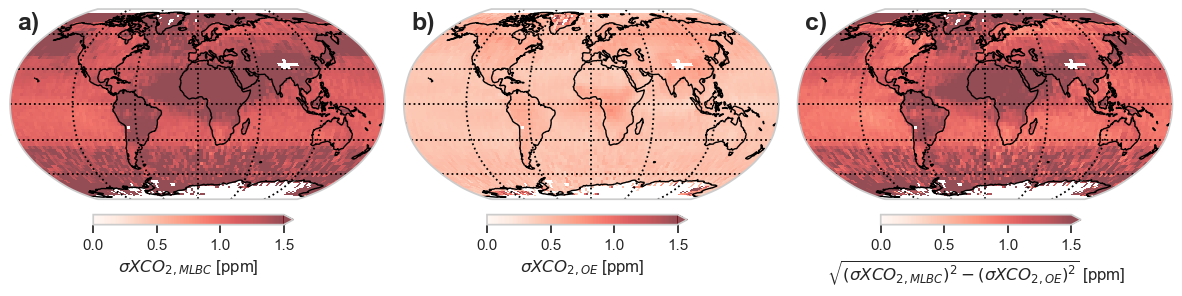

In [18]:
# plot bias_correction_uncert, xco2_uncertainty and (np.sqrt((data_train_ocn['bias_correction_uncert'] ** 2) - (data_train_ocn['xco2_uncertainty'] ** 2))
# each on a map 3 plots in a row
data_train['uq_filter_rms'] = np.abs((data_train['bias_correction_uncert'] ** 2) - (data_train['xco2_uncertainty'] ** 2))
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.Robinson()})
fig.subplots_adjust(hspace=0.05, wspace=0.05)
axs = axs.ravel()
letters = ["a)","b)","c)"]

r1, xedges, yedges = np.histogram2d(data_train['longitude'],data_train['latitude'],bins=[360//3, 180//3])
d1, _, _, = np.histogram2d(data_train['longitude'],data_train['latitude'],bins=[xedges, yedges], weights=(data_train['bias_correction_uncert']))
d1[d1==0.0] = np.nan
binned_bc_uncert = d1 / r1

im = axs[0].imshow(binned_bc_uncert.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Reds', vmin=0, vmax=1.5, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[0].coastlines(color = 'black', linewidth = 1.0)
axs[0].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[0].text(0.02, 0.99, letters[0], 
        verticalalignment='top', horizontalalignment='left',  transform=axs[0].transAxes, fontsize=18, weight = 'bold')

fig.colorbar(im, ax=axs[0], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='$\sigma XCO_{2,MLBC}$ [ppm]')

r1, xedges, yedges = np.histogram2d(data_train['longitude'],data_train['latitude'],bins=[360//3, 180//3])
d1, _, _, = np.histogram2d(data_train['longitude'],data_train['latitude'],bins=[xedges, yedges], weights=(data_train['xco2_uncertainty']))
d1[d1==0.0] = np.nan
binned_bc_uncert = d1 / r1

im = axs[1].imshow(binned_bc_uncert.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Reds',vmin=0, vmax=1.5, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[1].coastlines(color = 'black', linewidth = 1.0)
axs[1].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[1].text(0.02, 0.99, letters[1], 
        verticalalignment='top', horizontalalignment='left',  transform=axs[1].transAxes, fontsize=18, weight = 'bold')
fig.colorbar(im, ax=axs[1], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='$\sigma XCO_{2,OE}$ [ppm]')

r1, xedges, yedges = np.histogram2d(data_train['longitude'],data_train['latitude'],bins=[360//3, 180//3])
d1, _, _, = np.histogram2d(data_train['longitude'],data_train['latitude'],bins=[xedges, yedges], weights=( np.sqrt(data_train['uq_filter_rms'])))
d1[d1==0.00000] = np.nan
binned_bc_uncert = d1 / r1

im = axs[2].imshow(binned_bc_uncert.T, interpolation='nearest', origin='lower',
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap = 'Reds',vmin=0, vmax=1.5, transform=ccrs.PlateCarree(), alpha = 0.7)
axs[2].coastlines(color = 'black', linewidth = 1.0)
axs[2].gridlines(linestyle='dotted', linewidth = 1.3, color = 'black')
axs[2].text(0.02, 0.99, letters[2], 
        verticalalignment='top', horizontalalignment='left',  transform=axs[2].transAxes, fontsize=18, weight = 'bold')
fig.colorbar(im, ax=axs[2], orientation='horizontal', fraction=0.026, pad=0.04, extend='max', label='$\sqrt{(\sigma XCO_{2,MLBC})^{2} - (\sigma XCO_{2,OE})^{2}}$ [ppm]')

plt.savefig("uncertainty_maps.pdf", dpi = 300)
plt.show()

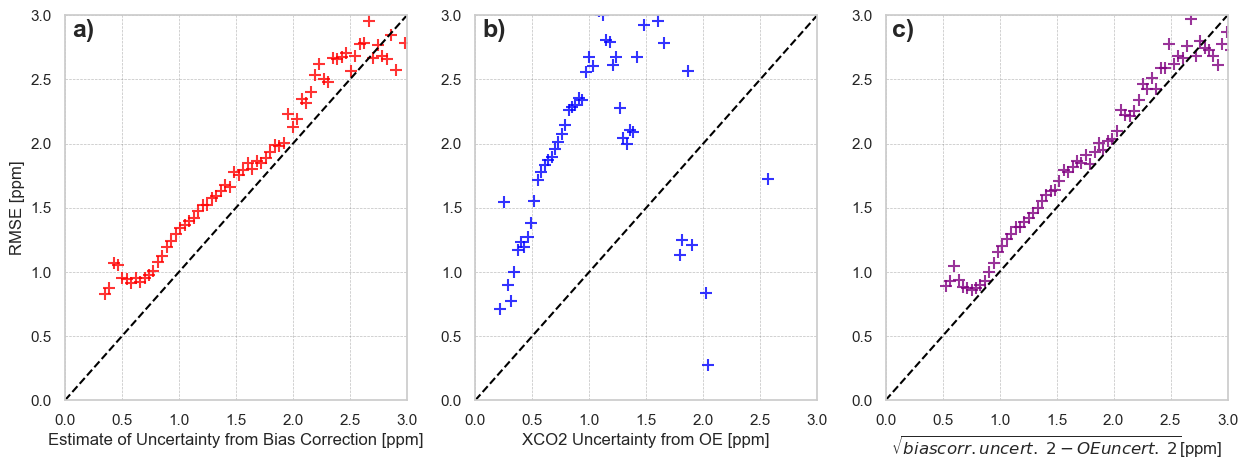

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()
d = pd.DataFrame({'bias_correction_uncert' : data_train[data_train['xco2tccon'].notnull()]['bias_correction_uncert'],
                    'xco2_diff_ML_TC' : data_train[data_train['xco2tccon'].notnull()]['xco2MLcorr'] - data_train[data_train['xco2tccon'].notnull()]['xco2tccon'],
                    'xco2_uncert' : data_train[data_train['xco2tccon'].notnull()]['xco2_uncertainty'],
                    'xco2_snr_uncert' : np.sqrt(data_train[data_train['xco2tccon'].notnull()]['bias_correction_uncert']**2 + data_train[data_train['xco2tccon'].notnull()]['xco2_uncertainty']**2)
                    
                    })
letters = ['a)', 'b)', 'c)']
for i in range(3):
    if i == 0:
        bins = np.linspace(d['bias_correction_uncert'].min(), d['bias_correction_uncert'].max(), 200)
        data_cut = pd.cut(d['bias_correction_uncert'], bins)
        grp = d.groupby(by = data_cut)
        ret_mean = grp.aggregate(np.mean)
        ret_sd = grp.aggregate(np.std)
        axs[i].scatter(ret_mean['bias_correction_uncert'], np.abs(ret_mean.xco2_diff_ML_TC) + ret_sd.xco2_diff_ML_TC, c = 'red', alpha= 0.8, s = 80, marker= '+')
        axs[i].plot([0,5],[0,5], c = 'black', linestyle = '--')
        axs[i].set_xlabel('Estimate of Uncertainty from Bias Correction [ppm]')
        axs[i].set_ylabel('RMSE [ppm]')
        axs[i].set_xlim([0.0,3.0])
        axs[i].set_ylim([0.0,3.0])
        axs[i].grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.5)
        axs[i].text(0.02, 0.99, letters[i], 
                    verticalalignment='top', horizontalalignment='left',  transform=axs[i].transAxes, fontsize=18, weight = 'bold')
    if i == 1:
        bins = np.linspace(d['xco2_uncert'].min(), d['xco2_uncert'].max(), 80)
        data_cut = pd.cut(d['xco2_uncert'], bins)
        grp = d.groupby(by = data_cut)
        ret_mean = grp.aggregate(np.mean)
        ret_sd = grp.aggregate(np.std)
        axs[i].scatter(ret_mean['xco2_uncert'], np.abs(ret_mean.xco2_diff_ML_TC) + ret_sd.xco2_diff_ML_TC, c = 'blue', alpha= 0.8, s = 80, marker= '+')
        axs[i].plot([0,5],[0,5], c = 'black', linestyle = '--')
        axs[i].set_xlabel('XCO2 Uncertainty from OE [ppm]')
        axs[i].set_ylabel('')
        axs[i].set_xlim([0.0,3.0])
        axs[i].set_ylim([0.0,3.0])
        axs[i].grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.5)
        axs[i].text(0.02, 0.99, letters[i], 
                    verticalalignment='top', horizontalalignment='left',  transform=axs[i].transAxes, fontsize=18, weight = 'bold')
    if i == 2:
        bins = np.linspace(d['xco2_snr_uncert'].min(), d['xco2_snr_uncert'].max(), 200)
        data_cut = pd.cut(d['xco2_snr_uncert'], bins)
        grp = d.groupby(by = data_cut)
        ret_mean = grp.aggregate(np.mean)
        ret_sd = grp.aggregate(np.std)
        axs[i].scatter(ret_mean['xco2_snr_uncert'], np.abs(ret_mean.xco2_diff_ML_TC) + ret_sd.xco2_diff_ML_TC, c = 'purple', alpha= 0.8, s = 80, marker= '+')
        axs[i].plot([0,5],[0,5], c = 'black', linestyle = '--')
        axs[i].set_xlabel('$\sqrt{bias corr. uncert.^ 2 - OE uncert. ^ 2}$[ppm]')
        axs[i].set_ylabel('')
        axs[i].set_xlim([0.0,3.0])
        axs[i].set_ylim([0.0,3.0])
        axs[i].grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.5)
        axs[i].text(0.02, 0.99, letters[i], 
                    verticalalignment='top', horizontalalignment='left',  transform=axs[i].transAxes, fontsize=18, weight = 'bold')
plt.show()



In [ ]:

import numpy as np, pandas as pd
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm   # nice progress bar in notebooks

"""
P_LAND  = 70    # percentile threshold for land (TC & SA)
P_OCEAN = 60    # percentile threshold for ocean
ABS_THRESH_LND = 1.30    # abstention threshold  (Chris metric)
ABS_THRESH_OCN = 1.05
CLASS_WEIGHT = dict(
    tc_lnd=(1.0, 1.0),
    tc_ocn=(2.0, 1.0),
    sa_lnd=(1.0, 1.15),
    sa_ocn=(1.0, 1.0),
)
SAVE_RF = False            # dump *.p models?


"""

KWARGS = dict(
    percentile_lnd            = 70,
    percentile_ocn            = 60,
    abstention_threshold_lnd  = 1.30,
    abstention_threshold_ocn  = 1.05,
    class_weight              = {
        "tc_lnd": (1.0, 1.0),
        "tc_ocn": (2.0, 1.0),
        "sa_lnd": (1.0, 1.15),
        "sa_ocn": (1.0, 1.0),
    },
    # NEW: (land_weighting , ocean_weighting)
    tccon_weighting           = (True, False),      #  land-only weighting
    save                      = False,
)

NEW_FLAG = "xco2_quality_flag_b112"

def rmse(a, b) -> float:
    diff = a - b
    return np.sqrt(np.nanmean(diff**2))

def station_list(df):
    """Valid stations (filter out Pasadena, Xianghe)."""
    good = df.loc[df["xco2tccon"] > 0, "tccon_name"].unique()
    return [s for s in good if s not in ("pasadena01", "xianghe01")]

def loso_cv(data_train, data_test,
            feats_sa=(feats_sa_lnd, feats_sa_ocn),
            feats_tc=(feats_tc_lnd, feats_tc_ocn),
            **kwargs):

    w_land, w_ocn = kwargs.pop("tccon_weighting", (True, True))

    def run_filter(df_tr, df_te, w_land, w_ocn):
        return build_ternary_filter(
            data_train            = df_tr,
            data_test             = df_te,
            feats_small_area_all  = feats_sa,
            feats_tccon_all       = feats_tc,
            tccon_weighting       = {"land": w_land, "ocean": w_ocn},
            **kwargs,
        )[1]                          # we only need the *test* output

    all_df  = pd.concat([data_train, data_test], ignore_index=True)
    results = []

    for st in tqdm(station_list(all_df), desc="LOSO folds"):
        tr = all_df[all_df["tccon_name"] != st].copy()
        te = all_df[all_df["tccon_name"] == st].copy()

        te_out = run_filter(tr, te, w_land, w_ocn)

        land_qf0  = te_out[(te_out["land_fraction"] == 100) & (te_out[NEW_FLAG] == 0)]
        ocean_qf0 = te_out[(te_out["land_fraction"] < 100)  & (te_out[NEW_FLAG] == 0)]

        results.append(dict(
            station    = st,
            n_land     = len(land_qf0),
            n_ocean    = len(ocean_qf0),
            rmse_land  = rmse(land_qf0["xco2MLcorr"],  land_qf0["xco2tccon"])  if len(land_qf0)  else np.nan,
            rmse_ocean = rmse(ocean_qf0["xco2MLcorr"], ocean_qf0["xco2tccon"]) if len(ocean_qf0) else np.nan,
        ))

    _, all_flagged, *_ = build_ternary_filter(
        data_train            = data_train,
        data_test             = data_test,
        feats_small_area_all  = feats_sa,
        feats_tccon_all       = feats_tc,
        tccon_weighting       = {"land": w_land, "ocean": w_ocn},
        **kwargs,
    )

    overall_land  = all_flagged[(all_flagged["land_fraction"] == 100) & (all_flagged[NEW_FLAG] == 0)]
    overall_ocean = all_flagged[(all_flagged["land_fraction"] < 100)  & (all_flagged[NEW_FLAG] == 0)]

    results.append(dict(
        station    = "__overall__",
        n_land     = np.nan,
        n_ocean    = np.nan,
        rmse_land  = rmse(overall_land["xco2MLcorr"],  overall_land["xco2tccon"]),
        rmse_ocean = rmse(overall_ocean["xco2MLcorr"], overall_ocean["xco2tccon"]),
    ))

    return (pd.DataFrame(results)
              .set_index("station")
              .sort_index())

cv_results = loso_cv(data_train, data_test, **KWARGS)

pd.set_option("display.float_format", "{:,.2f}".format)
print("\n===========  LOSO  RMSE  (ternary flag)  ===========")
display(cv_results[["n_land", "rmse_land", "n_ocean", "rmse_ocean"]])


LOSO folds:   0%|          | 0/21 [00:00<?, ?it/s]